In an earlier notebook, I showed how we can fit the parameters of a Bayesian mixture model using a Gibbs sampler. The sampler defines a Markov chain that, in steady state, samples from the posterior distribution of the mixture model. To move the chain forward by one step we:

* Sample the cluster assignment $z_i$.
* Sample the mixture weights $\pi$
* Sample the cluster means $\mu_n$.

It turns out that we can derive a Gibbs sampler that _just_ samples the assignments instead of the mixture weights and cluster means. This is known as a _collapsed_ Gibbs sampler. If we integrate out the cluster means $\theta_k$ and mixture weights from the margial distribution of cluster assignment $$p(z_i=k \,|\, \cdot)=
p(z_i=k \,|\, 
        z_{\neg i}, \pi,
        \theta_1, \theta_2, \theta_3, \sigma, \mathbf{x}, \alpha
        )$$ we are left with 
$$p(z_i\,|\, z_{\neg i}, \sigma, \mathbf{x}, \alpha).$$
        
By the conditional independence, we can factorize this marginal distribution 
$$p(z_i\,|\, z_{\neg i}, \sigma, \mathbf{x}, \alpha)\propto 
    p(z_i \,|\, z_{\neg i}, \alpha) p(x_i \,|\, z, x_{\neg_i}, \sigma).
$$
(_Note:_ I wish I could offer a more rigorous explanation of the preceeding statement, but time prohibits me figuring it out.)

The two terms have intuitive explanations. $p(z_i = k \,|\, z_{\neg i}, \alpha)$ is the probability point $x_i$ will be assigned to component $k$ given the current assignments. Because we are using a symmetric Dirichlet prior, this is the predictive likelihood of a Dirichlet-categorical distribution. This is given by:
$$p(z_i=k \,|\, z_{\not i}, \alpha)=
    \frac{N_k^{-i}+\alpha / K}{N-1+\alpha}$$
 where $N_k^{-i}=\sum_{j\neq i} \delta(z_j, k)$ is the number of observation assigned to $x_i$ (except $x_i$). We also need to define $\bar{x}_k^{-i}$ to be the mean of all observations assigned to component $k$ (except $x_i$).
 
The second term is the predictive likelihood that point $x_i$ is distributed according to cluster $k$ (given the data currently in cluster $k$). It can be rewritten:

$$
\begin{align}
p(x_i \,|\, z, x_{\neg_i}, \sigma)
&=p(x_i \,|\, z_i=k, z_{\neg i}, x_{\neg_i}, \sigma)\\
    &=p(x_i \,|\, \left\{x_j \,|\, z_j=k, j\neq i\right\}, \sigma).
\end{align}
    $$
    
For our example, we are assuming unknown cluster means are distributed according to a normal distribution with hyperparameter mean $\lambda_1$ and variance $\lambda_2^2$ and known cluster variance $\sigma^2$.

Thus, 
$$
\begin{align}
p(x_i \,|\, z, x_{\neg_i}, \sigma)
    &= \mathcal{N}(x_i \,|\, \mu_k, \sigma_k^2+\sigma^2)
\end{align}
    $$
where
$$\sigma_k^2 = \left( \frac{N_k^{-i}}{\sigma^2} + \frac{1}{\lambda_2^2} \right)^{-1}$$
and
$$\mu_k = \sigma_k^2 \left( 
    \frac{\lambda_1}{\lambda_2^2}+\frac{N_k^{-i}\cdot \bar{x}_k^{-i}}{\sigma^2}
\right).$$
This is derived in Kevin Murphey's fantastic article [Conjugate Bayesian analysis of the Gaussian distribution](http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf). 


At each step of the collapsed sampler, we sample each $z_i$ as follows:

* For each cluster $k$, compute $$f_k(x_i) =p(x_i \,|\, \left\{x_j \,|\, x_j=k, j\neq i\right\}, \lambda).$$ This is the predictive probability that $x_i$ is in cluster $k$ given the data currently assigned to that cluster.
* Sample $$z_i\sim \frac{1}{Z_i}\sum_{k=1}^K(N_k^{-i}+\alpha/K)f_k(x_i)\delta(z_i,k)$$

where the normalizing constant is $Z_i=\sum_{k=1}^K(N_k^{-i}+\alpha/K)f_k(x_i)$.


Let's load the same dataset we used previously:

In [2]:
import pandas as pd
data = pd.Series.from_csv("clusters.csv")
_=data.hist(bins=20)

Again, we want to define a state object and a function for updating the sufficient statistics of the state.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, Counter
from scipy import stats
from numpy import random

SuffStat = namedtuple('SuffStat', 'theta N')

def initial_state():
    num_clusters = 3
    alpha = 1.0
    cluster_ids = range(num_clusters)

    state = {
        'cluster_ids_': cluster_ids,
        'data_': data,
        'num_clusters_': num_clusters,
        'cluster_variance_': .01,
        'alpha_': alpha,
        'hyperparameters_': {
            "mean": 0,
            "variance": 1,
        },
        'suffstats': {cid: None for cid in cluster_ids},
        'assignment': [random.choice(cluster_ids) for _ in data],
        'pi': {cid: alpha / num_clusters for cid in cluster_ids},
    }
    update_suffstats(state)
    return state

def update_suffstats(state):
    for cluster_id, N in Counter(state['assignment']).iteritems():
        points_in_cluster = [x 
            for x, cid in zip(state['data_'], state['assignment'])
            if cid == cluster_id
        ]
        mean = np.array(points_in_cluster).mean()
        
        state['suffstats'][cluster_id] = SuffStat(mean, N)

Next we define functions to compute the two terms of our marginal distribution over cluster assignments.

In [59]:
def log_predictive_likelihood(data_id, cluster_id, state):
    """Predictive likelihood of the data at data_id is generated
    by cluster_id given the currenbt state.
    
    From Section 2.4 of 
    http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    ss = state['suffstats'][cluster_id]
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    param_var = state['cluster_variance_']
    x = state['data_'][data_id]
    posterior_sigma2 = 1 / (ss.N * 1. / param_var + 1. / hp_var)
    predictive_mu = posterior_sigma2 * (hp_mean * 1. / hp_var + ss.N * ss.theta * 1. / param_var)
    predictive_sigma2 = param_var + posterior_sigma2
    predictive_sd = np.sqrt(predictive_sigma2)
    return stats.norm(predictive_mu, predictive_sd).logpdf(x)


def log_cluster_assign_score(cluster_id, state):
    """Log-likelihood that a new point generated will
    be assigned to cluster_id given the current state.
    """
    current_cluster_size = state['suffstats'][cluster_id].N
    num_clusters = state['num_clusters_']
    alpha = state['alpha_']
    return np.log(current_cluster_size + alpha * 1. / num_clusters)

Given these two functions, we can compute the posterior probability distribution for assignment of a given datapoint. This is the core of our collapsed Gibbs sampler.

To simply the computation of things like $N_k^{-i}$ (where we remove point $i$ from the summary statistics, we create two simple functions to add and remove a point from the summary statistics for a given cluster. 

In [ ]:
def cluster_assignment_distribution(data_id, state):
    """Compute the marginal distribution of cluster assignment
    for each cluster.
    """
    scores = {}
    for cid in state['suffstats'].keys():
        scores[cid] = log_predictive_likelihood(data_id, cid, state)
        scores[cid] += log_cluster_assign_score(cid, state)
    scores = {cid: np.exp(score) for cid, score in scores.iteritems()}
    normalization = 1.0/sum(scores.values())
    scores = {cid: score*normalization for cid, score in scores.iteritems()}
    return scores

In [23]:
def add_datapoint_to_suffstats(x, ss):
    """Add datapoint to sufficient stats for normal component
    """
    return SuffStat((ss.theta*(ss.N)+x)/(ss.N+1), ss.N+1)


def remove_datapoint_from_suffstats(x, ss):
    """Remove datapoint from sufficient stats for normal component
    """
    return SuffStat((ss.theta*(ss.N)-x*1.0)/(ss.N-1), ss.N-1)

Finally, we're ready to create a function that takes a Gibbs step on the state. For each datapoint, it
1. Removes the datapoint from its current cluster.
2. Computes the posterior probability of the point being assigned to each cluster (given the other current assignments).
3. Assigns the datapoint to a cluster sampled from this probability distribution.

In [61]:
def gibbs_step(state):
    pairs = zip(state['data_'], state['assignment'])
    for data_id, (datapoint, cid) in enumerate(pairs):

        state['suffstats'][cid] = remove_datapoint_from_suffstats(datapoint, 
                                                                  state['suffstats'][cid])
        cluster_labels = state['suffstats'].keys()
        scores = cluster_assignment_distribution(data_id, state).items()
        labels, scores = zip(*scores)
        cid = random.choice(labels, p=scores)
        state['assignment'][data_id] = cid
        state['suffstats'][cid] = add_datapoint_to_suffstats(state['data_'][data_id], state['suffstats'][cid])

Here's our old function to plot the assignments.

In [62]:
def plot_clusters(state):
    gby = pd.DataFrame({
            'data': state['data_'], 
            'assignment': state['assignment']}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist() 
                 for cid in gby.groups.keys()]
    plt.hist(hist_data, 
             bins=20,
             histtype='stepfilled', alpha=.5 )

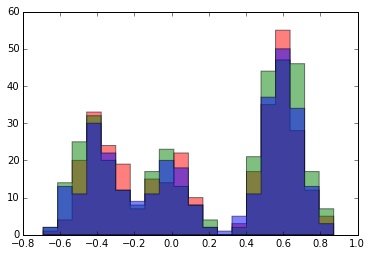

In [63]:
state = initial_state()
plot_clusters(state)

Look what happens to the assignments after one Gibbs step

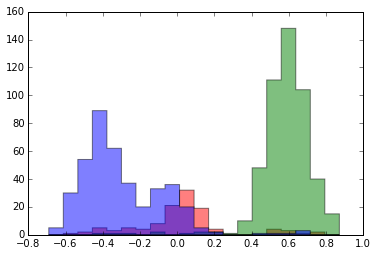

In [64]:
gibbs_step(state)
plot_clusters(state)

Two:

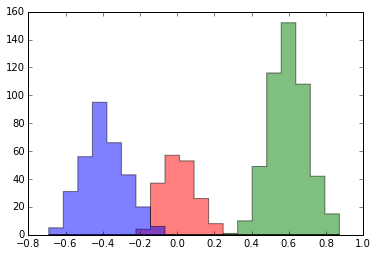

In [65]:
gibbs_step(state)
plot_clusters(state)

After just two steps, our assignments look _really_ good. We can run it a few more times and see the assignments again.

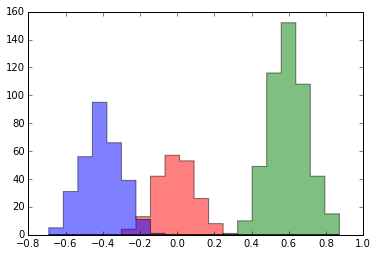

In [66]:
for _ in range(10): gibbs_step(state)
plot_clusters(state)

### Nonparametric Mixture Models!

It turns out, the collapsed Gibbs sampler for mixture models is almost identical in the context of a _nonparametric_ model. This model uses a _Dirichlet process prior_ instead of a _Dirichlet distribution prior_. It doesn't require us to specify how many clusters we are looking for in our data.

The cluster assignment score changes slightly. It is proportional to $N_k^{-i}$ for each known cluster. We assign a datapoint to a _new_ cluster with probability proportional to $\alpha$ (which is now the DP dispersion parameter).

In [5]:
def log_cluster_assign_score_dp(cluster_id, state):
    """Log-likelihood that a new point generated will
    be assigned to cluster_id given the current state.
    """
    if cluster_id == "new":
        return np.log(state["alpha_"])
    else:
        return np.log(state['suffstats'][cluster_id].N)

The predictively likelihood remains the same for known clusters. However, we need to know the likelihood of assigning a datapoint to a new cluster. In this case, we fall back on the hyperparameters to get:

$$
\begin{align}
p(x_i \,|\, z, x_{\neg_i}, \sigma)
    &= \mathcal{N}(x_i \,|\, \lambda_1, \lambda_2^2+\sigma^2)
\end{align}
    $$

In [25]:
def log_predictive_likelihood_dp(data_id, cluster_id, state):
    """Predictive likelihood of the data at data_id is generated
    by cluster_id given the currenbt state.
    
    From Section 2.4 of 
    http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    if cluster_id == "new":
        ss = SuffStat(0, 0)
    else:
        ss = state['suffstats'][cluster_id]
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    param_var = state['cluster_variance_']
    x = state['data_'][data_id]
    posterior_sigma2 = 1 / (ss.N * 1. / param_var + 1. / hp_var)
    predictive_mu = posterior_sigma2 * (hp_mean * 1. / hp_var + ss.N * ss.theta * 1. / param_var)
    predictive_sigma2 = param_var + posterior_sigma2
    predictive_sd = np.sqrt(predictive_sigma2)
    return stats.norm(predictive_mu, predictive_sd).logpdf(x)

Given this, we can define the marginal distribution over cluster assignment. The only change is that the "new" state enters in the distribution.

In [30]:
def cluster_assignment_distribution_dp(data_id, state):
    """Compute the marginal distribution of cluster assignment
    for each cluster.
    """
    scores = {}
    for cid in state['suffstats'].keys() + ["new"]:
        scores[cid] = log_predictive_likelihood_dp(data_id, cid, state)
        scores[cid] += log_cluster_assign_score_dp(cid, state)
    scores = {cid: np.exp(score) for cid, score in scores.iteritems()}
    normalization = 1.0/sum(scores.values())
    scores = {cid: score*normalization for cid, score in scores.iteritems()}
    return scores

In [31]:
def create_cluster(state):
    state["num_clusters_"] += 1
    cluster_id = max(state['suffstats'].keys()) + 1
    state['suffstats'][cluster_id] = SuffStat(0, 0)
    state['cluster_ids_'].append(cluster_id)
    return cluster_id

def destroy_cluster(state, cluster_id):
    state["num_clusters_"] = 1
    del state['suffstats'][cluster_id]
    state['cluster_ids_'].remove(cluster_id)

In [36]:
def gibbs_step_dp(state):
    pairs = zip(state['data_'], state['assignment'])
    for data_id, (datapoint, cid) in enumerate(pairs):
        state['suffstats'][cid] = remove_datapoint_from_suffstats(datapoint, 
                                                                  state['suffstats'][cid])
        cluster_labels = state['suffstats'].keys()
        scores = cluster_assignment_distribution_dp(data_id, state).items()
        labels, scores = zip(*scores)
        cid = random.choice(labels, p=scores)
        if cid == "new":
            cid = create_cluster(state)
        else:
            cid = int(cid)
        state['assignment'][data_id] = cid
        state['suffstats'][cid] = add_datapoint_to_suffstats(state['data_'][data_id], state['suffstats'][cid])
        
        for cid in state['cluster_ids_']:
            if state['suffstats'][cid].N == 0:
                destroy_cluster(state, cid)

In [45]:
#%debug
state = initial_state()
state['alpha_'] = 0.05
gibbs_step_dp(state)

In [46]:
for _ in range(20):
    gibbs_step_dp(state)
state['suffstats']

{0: SuffStat(theta=0.1132175518187713, N=37),
 1: SuffStat(theta=-0.038797853420923512, N=178),
 3: SuffStat(theta=-0.41245721430815702, N=294),
 4: SuffStat(theta=0.59790337196469256, N=491)}